<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/segmentationQC_trackingQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

# Segmentation quality control

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

### Load required libraries 

In [ ]:
import numpy as np
from ipywidgets import interact, widgets, Layout
import matplotlib.pyplot as plt
from skimage.io import imread, imsave, imshow
from skimage import data, filters, measure, morphology
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import ntpath
import os
import pickle
import re
import copy
import scipy
from scipy import ndimage

In [ ]:
#Get from Drive the folder libraries
!cp -r /content/drive/MyDrive/libraries /content

from libraries.filter_cells_fns import *
from libraries.centers import get_centers

### Copy data from GCP to Colab

In [ ]:
#@markdown ###Type path to images and masks:

#@markdown folderimages is is the path to the folder containing the images from a sample. Can be copied from GCP.

imagespath='cellmbucket/03122021-JR20P14-control/sample5'#@param {type:"string"}

#@markdown maskspath is the path to the .zip file containing a folder with the masks to the corresponding sample. Can be copied from GCP
maskspath = 'cellmbucket/03122021-JR20P14-control-masks/031221_control_sample5_pred_cell_nuc_masks.zip' #@param {type:"string"}

#@markdown nucmaskspath is the path to the .zip file containing a folder with the nclear masks to the corresponding sample. Can be copied from GCP
nucmaskspath = 'cellmbucket/03122021-JR20P14-control-masks/03122021-control-sample5-nuc-masks.zip' #@param {type:"string"}



#### Copy images from GCP to colab. Separate tif movies into indidivual files

In [ ]:
#Copy folder containing images in a sample
!gsutil -m cp -r gs://{imagespath} /content


Copying gs://cellmbucket/03122021-JR20P14-control/sample5/.DS_Store...
Copying gs://cellmbucket/03122021-JR20P14-control/sample5/10_steepz2.tif...
Copying gs://cellmbucket/03122021-JR20P14-control/sample5/13_soft.tif...
Copying gs://cellmbucket/03122021-JR20P14-control/sample5/12_steepz2.tif...
Copying gs://cellmbucket/03122021-JR20P14-control/sample5/14_soft.tif...
Copying gs://cellmbucket/03122021-JR20P14-control/sample5/15_soft.tif...
Copying gs://cellmbucket/03122021-JR20P14-control/sample5/11_steepz2.tif...
Copying gs://cellmbucket/03122021-JR20P14-control/sample5/1_stiff.tif...
Copying gs://cellmbucket/03122021-JR20P14-control/sample5/3_stiff.tif...
Copying gs://cellmbucket/03122021-JR20P14-control/sample5/2_stiff.tif...
Copying gs://cellmbucket/03122021-JR20P14-control/sample5/4_stiff.tif...
Copying gs://cellmbucket/03122021-JR20P14-control/sample5/5_line or steep zone 1.tif...
Copying gs://cellmbucket/03122021-JR20P14-control/sample5/6_line.tif...
Copying gs://cellmbucket/03122

In [ ]:
#get folder conatining the images
folderimages= ntpath.basename(imagespath)

In [ ]:
!ls {folderimages}

 10_steepz2.tif   14_soft.tif   3_stiff.tif		      7_line.tif
 11_steepz2.tif   15_soft.tif   4_stiff.tif		      8_line.tif
 12_steepz2.tif   1_stiff.tif  '5_line or steep zone 1.tif'   9_steepz2.tif
 13_soft.tif	  2_stiff.tif   6_line.tif		      Thumbs.db


In [ ]:
#Separate .tif movies into individual images .TIF
#this step has to be done in the same way as in the segmentation notebook
names_movies=[f for f in os.listdir(folderimages) if f.endswith('.tif')]
for name in names_movies:
  movie=imread(folderimages+'/'+name)
  s=re.findall(r"(\d+)_", name)
  for i in range(movie.shape[0]):
    imagename = folderimages + '_s'+s[0]+'_t'+str(i+1)+'.TIF'
    imsave(folderimages + '/' + imagename, movie[i])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: sample5/sample5_s6_t35.TIF is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: sample5/sample5_s6_t36.TIF is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: sample5/sample5_s6_t37.TIF is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: sample5/sample5_s6_t38.TIF is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: sample5/sample5_s6_t39.TIF is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: sample5/sample5_s6_t40.TIF is a low contrast image
  if __name__ == '__main__':
/usr/lo

#### Copy masks from GCP to colab

In [ ]:
#Cell masks

#Copy and extract masks
!gsutil cp gs://{maskspath} /content
!unzip {ntpath.basename(maskspath)}

#Get the name of the folder containing the masks, same name of the .zip file
foldermasks= ntpath.basename(maskspath)[:-4]


Copying gs://cellmbucket/03122021-JR20P14-control-masks/031221_control_sample5_pred_cell_nuc_masks.zip...
- [1 files][  3.2 MiB/  3.2 MiB]                                                
Operation completed over 1 objects/3.2 MiB.                                      
Archive:  031221_control_sample5_pred_cell_nuc_masks.zip
   creating: 031221_control_sample5_pred_cell_nuc_masks/
  inflating: 031221_control_sample5_pred_cell_nuc_masks/sample5_s11_t84.TIF  
  inflating: 031221_control_sample5_pred_cell_nuc_masks/sample5_s11_t5.TIF  
  inflating: 031221_control_sample5_pred_cell_nuc_masks/sample5_s11_t61.TIF  
  inflating: 031221_control_sample5_pred_cell_nuc_masks/sample5_s1_t35.TIF  
  inflating: 031221_control_sample5_pred_cell_nuc_masks/sample5_s3_t18.TIF  
  inflating: 031221_control_sample5_pred_cell_nuc_masks/sample5_s1_t76.TIF  
  inflating: 031221_control_sample5_pred_cell_nuc_masks/sample5_s4_t24.TIF  
  inflating: 031221_control_sample5_pred_cell_nuc_masks/sample5_s3_t4.TIF  


In [ ]:
#Nuclei masks

#Copy and extract masks
!gsutil cp gs://{nucmaskspath} /content
!unzip {ntpath.basename(nucmaskspath)}

#Get the name of the folder containing the masks, same name of the .zip file
foldernucmasks= ntpath.basename(nucmaskspath)[:-4]

Copying gs://cellmbucket/03122021-JR20P14-control-masks/03122021-control-sample5-nuc-masks.zip...
/ [1 files][  1.4 MiB/  1.4 MiB]                                                
Operation completed over 1 objects/1.4 MiB.                                      
Archive:  03122021-control-sample5-nuc-masks.zip
   creating: 03122021-control-sample5-nuc-masks/
  inflating: 03122021-control-sample5-nuc-masks/sample5_s3_t80.TIF  
  inflating: 03122021-control-sample5-nuc-masks/sample5_s1_t74.TIF  
  inflating: 03122021-control-sample5-nuc-masks/sample5_s14_t49.TIF  
  inflating: 03122021-control-sample5-nuc-masks/sample5_s9_t162.TIF  
  inflating: 03122021-control-sample5-nuc-masks/sample5_s9_t31.TIF  
  inflating: 03122021-control-sample5-nuc-masks/sample5_s13_t144.TIF  
  inflating: 03122021-control-sample5-nuc-masks/sample5_s9_t67.TIF  
  inflating: 03122021-control-sample5-nuc-masks/sample5_s7_t57.TIF  
  inflating: 03122021-control-sample5-nuc-masks/sample5_s15_t59.TIF  
  inflating: 03

### Set contrast

#### Look at the histogram of intensity of some images

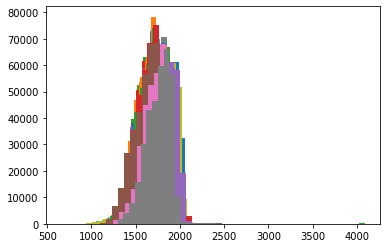

In [ ]:
#Get name of images (end with .TIF)
imagenames=[f for f in os.listdir(folderimages) if f.endswith('.TIF')]
#Plot some pixel histograms
for i in range(0,len(imagenames),100):
  image=imread(folderimages+'/'+imagenames[i])
  plt.hist(image.ravel(),50)

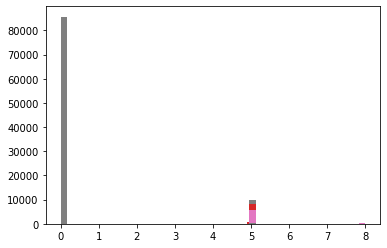

In [ ]:
#Histogram of masks, the peaks are background, membrane, nuclei
#from segmentation step masks should have the same names as images
for i in range(0,len(imagenames),100):
  image=imread(foldermasks+'/'+imagenames[i])
  plt.hist(image.ravel(),50)

#### Set bounds of intensity

In [ ]:
minintensity=900 #@param {type:"integer"}
maxintensity=2250 #@param {type:"integer"}

### Find number of frames per movie and image basename

In [ ]:
imagenames=[f for f in os.listdir(folderimages) if f.endswith('.TIF')]

In [ ]:
#Get movie numbers and show the largest number
listmovies=[int(re.findall(r"s(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
max(listmovies)

15

In [ ]:
#Get frame numbers and show the largest number
listframes=[int(re.findall(r"t(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
max(listframes)

181

In [ ]:
imagenames[0]

'sample5_s5_t20.TIF'

In [ ]:
#@markdown This is the name of the files from the beginning before "_s"
imagebasename='sample5'#@param {type:"string"}


### Load separate cell masks and nucleus masks and visualize together

In [ ]:
%%capture

#First movie
movie=13 #@param {type:"integer"}

#Number of frames in movie
nframes=181 #@param {type:"integer"}

#Sampling frame rate
frspace=1 #@param {type:"integer"}

#Mask intensity for combined image
#mfrac=0.3 #@param {type:"number"}

remove_cells_touching_edge = False #@param {type:"boolean"}

remove_multi_nuclei_cells = False #@param {type:"boolean"}

#@markdown ### Size bounds (number of pixels)



filter_cell_size = True #@param {type:"boolean"}

pixelsize_um=1.29 #@param {type:"number"}
#minarea=600
#maxarea=3200
#nucminarea=21*pixelsize**2

minareacell=150 #@param {type:"integer"}
maxareacell=15000 #@param {type:"integer"}

filter_nuc_size = True #@param {type:"boolean"}
minareanuc=30 #@param {type:"integer"}



frames=range(1,nframes+1,frspace)
frpermov=len(frames)
combineds=[]
for i in frames:
    #membrane
    maskmem=imread(foldermasks+'/'+imagebasename + "_s" + str(movie)+"_t"+str(i)+".TIF")
    maskmem[maskmem>0]=1
    #fill holes
    maskmem=ndimage.binary_fill_holes(maskmem).astype(int)

    #nuclei
    masknuc=imread(foldernucmasks+'/'+imagebasename +  "_s" + str(movie)+"_t"+str(i)+".TIF")
    masknuc[masknuc>0]=1

    #label different objectes in masks
    maskmem = measure.label(maskmem)
    masknuc=measure.label(masknuc)
    
    #FILTERS
    if remove_cells_touching_edge == True:
      maskmem=remove_touching_edge(maskmem)
    
    if filter_cell_size == True:
      maskmem = morphology.remove_small_objects(maskmem, minareacell,in_place=True)       
      maskmem = remove_large_objects(maskmem, maxareacell)
    
    if filter_nuc_size == True:
      masknuc = morphology.remove_small_objects(masknuc, minareanuc,in_place=True)       
    
    if remove_multi_nuclei_cells == True:
      maskmem = remove_multiple_nuclei_cells(maskmem,masknuc)
    
    
    #masks.append(mask)
    #read image
    imageorig=imread(folderimages + '/' + imagebasename + "_s" + str(movie)+"_t"+str(i)+".TIF")
    #rescale image intensity
    image=rescale_intensity(imageorig,(minintensity,maxintensity))            
    #rescale image
    image=resize(image, (image.shape[0] * 0.5 , image.shape[1] * 0.5),  anti_aliasing=True)
    #combine transparently mask and image
    
    #unlabel for visualization
    maskmem[maskmem>0]=1
    masknuc[masknuc>0]=1
    maskcomb=maskmem-0.5*masknuc

    #mask=mask/8.
    #mask[mask>0]=1
    #maskres=resize(mask,(int(mask.shape[0]*0.5), int(mask.shape[1]*0.5)),  anti_aliasing=True )
    #combined = mfrac*mask*np.mean(image) + (1-mfrac)*image
    combined=np.hstack((image,maskcomb))
    #masknuc=masknuclabeled
    #masknuc[masknuc>0]=1         
    #imagenuc = mfrac*masknuc*np.mean(image) + (1-mfrac)*image
    #mask[mask>0]=1         
    #combineds.append(np.hstack((mask,imagenuc)))
    combineds.append(combined)

def f(frame):
    
    l.set_data(combineds[frame-1])
    fig.canvas.draw() #use with %matplotlib notebook
    display(fig) #use with %matplotlib inline
    #plt.imshow(img_median, cmap="gray") #This would work
    #plt.show()

fig = plt.figure(figsize=(14, 8))
ax_mask = fig.add_subplot(111) 
l = ax_mask.imshow(combineds[0], cmap="gray")
#interact(f, frame=widgets.IntSlider(min=1,max=110,step=2,value=1,layout=Layout(width='90%', height='20px'))) 

In [ ]:
interact(f, frame=widgets.IntSlider(min=1,max=len(combineds),step=1,value=1,msg_throttle=1,layout=Layout(width='90%', height='40px'))) 

interactive(children=(IntSlider(value=1, description='frame', layout=Layout(height='40px', width='90%'), max=9…

<function __main__.f>

#Get cell features (table), labeled masks, and track

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

### Load required libraries 

In [ ]:
import numpy as np
from ipywidgets import interact, widgets, Layout
import matplotlib.pyplot as plt
from skimage.io import imread, imsave, imshow
from skimage import data, filters, measure, morphology
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import ntpath
import os
import pickle
import re
import copy
import scipy
from scipy import ndimage

In [ ]:
#Get from Drive the folder libraries
!cp -r /content/drive/MyDrive/libraries /content

from libraries.filter_cells_fns import *
from libraries.centers import get_centers

### Set output folder and experiment

In [ ]:
#@markdown folder_output is the name of the folder that will contain the output files (labeled masks, cell features)

folder_output = 'analysis_041621' #@param {type:"string"}

#@markdown experiment is a label to name output files. It should reflect the name of the folder containing the images

experiment='031221_control_sample6'  #@param {type:"string"}

### Input paths and copy masks with cells and nuclei and masks with only nuclei 

In [ ]:


#@markdown Below is the paths to the masks containing cells and nuclei in the GCP bucket

cell_nuc_maskspath='cellmbucket/03122021-JR20P14-control-masks/031221_control_sample6_pred_cell_nuc_masks.zip' #@param {type:"string"}
nuc_maskspath='cellmbucket/03122021-JR20P14-control-masks/03122021-control-sample6-nuc-masks.zip' #@param {type:"string"}

#@markdown Hidden is the code to get the cell_nuc masks and nuc masks from GCP and make  only cell masks from cell_nuc masks


#Copy and extract cell masks and get folder name
!gsutil -m cp gs://{cell_nuc_maskspath} /content
!unzip {ntpath.basename(cell_nuc_maskspath)}
folder_cellmasks = ntpath.basename(cell_nuc_maskspath)[:-4]

#Copy and extract nucleus masks and get folder name
!gsutil -m cp gs://{nuc_maskspath} /content
!unzip {ntpath.basename(nuc_maskspath)}
folder_nucmasks = ntpath.basename(nuc_maskspath)[:-4]


#get cell_nuc_masks names
masknames=[f for f in os.listdir(folder_cellmasks) if f.endswith('.TIF')]

#Edit masks so that they contain only zeroes (backgroud) and ones (objects) 

for maskname in masknames:
  maskcell=imread(folder_cellmasks + '/' + maskname)
  #Get mask of only cell membrane
  maskcell[maskcell != 0] = 1
  #fill holes
  maskcell=ndimage.binary_fill_holes(maskcell).astype(int)
  imsave(folder_cellmasks + '/' + maskname, maskcell)

  #Get mask of only nucleus
  masknuc=imread(folder_nucmasks + '/' + maskname)
  masknuc[masknuc != 0] = 1
  imsave(folder_nucmasks + '/' + maskname, masknuc) 


In [ ]:
masknames[0]

'sample5_s14_t129.TIF'

In [ ]:
imshow(folder_nucmasks+'/'+masknames[0])

### Make list with movies, frames per movie, and get image basename from the full name of an image

In [ ]:
#Get list of movies
movies = [int(re.findall(r"s(\d+).", masknames[i])[0]) for i in range(len(masknames)) ]
#get set of unique elements
movies = list(set(movies))
#sort
movies.sort()
nmovies=len(movies)
movies

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [ ]:
#Get frame numbers and show the largest number
listframes=[int(re.findall(r"t(\d+).", masknames[i])[0]) for i in range(len(masknames)) ]
nframes=max(listframes)
frames=range(1,nframes+1)
nframes

181

In [ ]:
masknames[0]
basename= re.findall(r"(.*)_s",masknames[0])[0]
basename

'sample6'

### Input filters and get cell shape features applying filters (cell size, remove multi nuclei cells). Get labeled masks. Save data in folder_output and transfer to GCP bucket (hidden code) This step can take ~ 3 min

In [ ]:
%%time

sampling_min=10 #@param {type:"integer"}
pixelsize_um=1.29 #@param {type:"number"}
#area bounds in pixels
minareanuc=21 #@param {type:"integer"}
minareacell=200 #@param {type:"integer"}
maxareacell=10000 #@param {type:"integer"}
#maxareacell=3200

!mkdir {folder_output}

reading_cells_parameters={'experiment':experiment, 'basename':basename,
                   'nmovies':nmovies,'nframes':nframes, 'sampling_min':sampling_min,
                   'pixelsize_um':pixelsize_um, 'minareanuc':minareanuc,
                     'minareacell':minareacell, 'maxareacell':maxareacell}


with open(folder_output+'/'+experiment+'_reading_cells_parameters.pkl', 'wb') as handle:
    pickle.dump(reading_cells_parameters, handle)

#SAVE LABELED MASK SO THAT FEATURES CAN BE EXTRACTED AFTER TRACKING
folder_maskscell_labeled = experiment + '_labeledmasks' 
!mkdir {folder_maskscell_labeled}

def getcells(filename,filenamenuc):     
    
  #read  cells and nuclei mask
  mask =imread(filename)
  masknucorig =imread(filenamenuc)
  #label objects in mask
  maskl = measure.label(mask)
  masknuclabeled=measure.label(masknucorig)

  #FILTERS
  
  maskl=remove_touching_edge(maskl)
  maskl = morphology.remove_small_objects(maskl, minareacell,in_place=True)       
  maskl = remove_large_objects(maskl, maxareacell)
  masknuclabeled = morphology.remove_small_objects(masknuclabeled, minareanuc,in_place=True)       
  maskl = remove_multiple_nuclei_cells(maskl,masknuclabeled)    

  #if there are cells get metrics
  ids=set(np.ravel(maskl))
  #remove 0 (background) from ids
  ids.remove(0)
  if len(ids) > 0:
     
    #cellsmetrics = measure.regionprops_table(maskl, properties=('label','orientation','area',
    #                                            'major_axis_length',    
    #                                            'minor_axis_length','eccentricity'))
    
    cellsmetrics = measure.regionprops_table(maskl, properties=('label','area','eccentricity','orientation','perimeter','solidity','major_axis_length','minor_axis_length'))        
    cellsmetrics=pd.DataFrame(cellsmetrics)

    #GET CENTERS
    #get labels
    labels=cellsmetrics['label']    
    #Because 'label' was copied from the table, after computing the centers 
    #and concatenating them to the table they should be in the right order
    centers=get_centers(maskl,'approximate-medoid',labels, False)
    #add centers to cell properties
    appmedoid=pd.DataFrame(data=np.asarray(centers),columns=['approximate-medoidx','approximate-medoidy'])
    cellsmetrics=pd.concat([cellsmetrics,appmedoid],1)
    
    centers=get_centers(maskl,'centroid',labels, False)
    #add centers to cell properties
    centroid=pd.DataFrame(data=np.asarray(centers),columns=['centroidx','centroidy'])
    cellsmetrics=pd.concat([cellsmetrics,centroid],1)
    
    #centers=get_centers(maskl,'largest-circle',labels, False)
    ##add centers to cell properties
    #largecircle=pd.DataFrame(data=np.asarray(centers),columns=['largecirclex','largecircley'])
    #cellsmetrics=pd.concat([cellsmetrics,largecircle],1)

  else:
    cellsmetrics=[]
  
  return cellsmetrics, maskl 

#not necessary to specify columns, but this way 'movie' and 'frame' will be at the beginning of the cells data frame
cellmetrics=pd.DataFrame(columns=['movie','frame'])

for s in movies:
    for fr in frames:
        filename = folder_cellmasks+'/'+basename + "_s" + str(s)+'_t'+str(fr)+'.TIF'
        filenamenuc = folder_nucmasks +'/'+ basename + "_s" + str(s)+'_t'+str(fr)+'.TIF'
        
        #get cell features in a mask and the labeled mask
        metricsmaskcells, maskcellslab = getcells(filename,filenamenuc)
        #SAVE LABELED MASK SO THAT FEATURES CAN BE EXTRACTED AFTER TRACKING
        imsave(folder_maskscell_labeled + '/' + basename + "_s" + str(s)+'_t'+str(fr)+'.TIF' , maskcellslab)
        if len(metricsmaskcells) > 0:
          #Add columns corresponding to movie and frame
          #currcells['experiment']=experiment
          metricsmaskcells['movie']=s
          metricsmaskcells['frame']=fr
          #adds metricsmaskcells below cells
          cellmetrics=cellmetrics.append(metricsmaskcells, ignore_index=True)

!zip -r {folder_maskscell_labeled}.zip {folder_maskscell_labeled}

!cp {folder_maskscell_labeled}.zip {folder_output}

cellmetrics.to_csv(folder_output +'/' + experiment + '_cell_features.csv')

with open(folder_output+'/'+experiment+'_reading_cells_parameters.pkl', 'wb') as handle:
    pickle.dump(reading_cells_parameters, handle)

!gsutil -m cp -r /content/{folder_output} gs://cellmbucket

In [ ]:
cellmetrics.iloc[0:10]

In [ ]:
len(cellmetrics)

3447

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


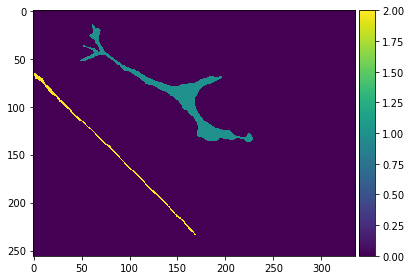

In [ ]:
imshow(folder_maskscell_labeled+'/'+masknames[9])

## Input tracking parameters and track 

Reads cell_features from folder_output in GCP bucket, writes tracking_parameters and tracks to folder_output in GCP bucket

centertype can be either "centroid" or "approximate-medoid"

maxdist is the maximum distance in pixels allowed for a cell jump

dfracsize is the maximum fractional change in area allowed

The output (tracks) should be a file in the output folder ending with "tracks.pkl" containing a list of tables (each table is a track)

In [ ]:
%%time
centertype='approximate-medoid' #@param {type:"string"}
#@markdown maximum jump size allowed in um
maxdist_um =  50#@param {type:"integer"}
#@markdown maximum fractional area change 
dfracsize=10000 #@param {type:"number"}

maxdistpixels = maxdist_um/pixelsize_um
maxdist2=maxdistpixels**2

trackinging_parameters={'centertype':centertype, 'maxdist':maxdist_um, 'dfracsize':dfracsize}

with open(experiment + '_tracking_parameters.pkl', 'wb') as handle:
    pickle.dump(trackinging_parameters, handle)

#This specify the cell metrics tracking is going to use
fields = ['label','movie','frame',centertype+'x',centertype+'y','area']

#copy cell shape features from bucket to colab
!gsutil -m cp gs://cellmbucket/{folder_output}/{experiment}_cell_features.csv /content/

#read cell shape features as data frame
sample_cells = pd.read_csv(experiment + '_cell_features.csv', usecols=fields)

sample=[]
for s in movies:
    tracks=[]
    activetr=[] #contains indices of active tracks    
    for fr in frames:
        #if no active tracks 
        if len(activetr)==0:
            #get cells in current frame                  
            maskcells = sample_cells[(sample_cells['movie']==s) & (sample_cells['frame']==fr)]
            #print(maskcells)
            #if there are cells: initialize tracks
            if len(maskcells)>0:
                for i in range(len(maskcells)):
                    tracks.append(maskcells.iloc[[i]].reset_index(drop=True))
                    activetr.append(len(tracks)-1)
                    
            #if no cells. do nothing go to next frame
            
        #else, there are active tracks, get cells in current frame     
        else:          
            #get cells in current frame
            maskcells = sample_cells[(sample_cells['movie']==s) & (sample_cells['frame']==fr)]
            #if no cells: end all current tracks, go to next frame
            if len(maskcells)==0: activetr=[]
            
            #else, there are cells, DO TRACKING    
            else: 
                #make list of empty active tracks candidates for each cell in mask
                cand=[[] for i in range(len(maskcells)) ]               
                #for each active track find which cell could be next in track
                #if a cell is found for a track, store track in list of canidates of cell
                for act in activetr:
                    #find closest element in mask
                    closedist2=100000000
                    closecell=-1
                    for i in range(len(maskcells)):
                        
                        dist2=(maskcells.iloc[i][centertype+'x']-tracks[act][centertype+'x'].iloc[-1])**2 + (maskcells.iloc[i][centertype+'y']-tracks[act][centertype+'y'].iloc[-1])**2
                        if dist2 < closedist2:
                            closecell=i
                            closedist2=dist2
                    #RESTRICTIONS TO ADD A CELL TO A TRACK: DISTANCE AND CHANGE IN AREA
                    if closedist2 < maxdist2 and maskcells.iloc[closecell]['area'] > tracks[act]['area'].iloc[-1]*(1-dfracsize) and maskcells.iloc[closecell]['area'] < tracks[act]['area'].iloc[-1]*(1+dfracsize):
                        #add act to candidate list of closecell
                        cand[closecell].append(act)
                    else:
                    #the closest cell to track does not qualify: track ends
                        #print fr, np.sqrt(closedist2), tracks[act]['area'].iloc[-1]*(1-dfracsize), maskcells[closecell].area, tracks[act]['area'].iloc[-1]*(1+dfracsize)
                        activetr.remove(act)            
                #go through each cell in mask and from the list of candidate tracks pick only one        
                for k in range(len(cand)):
                    #if object k in mask had no candidates after iterating activetracks
                    if len(cand[k])==0:
                        #generate new track starting with the unmatched object in mask
                        tracks.append(maskcells.iloc[[k]].reset_index(drop=True))
                        activetr.append(len(tracks)-1)
                        
                    #if object k in mask has only one candidate track     
                    elif len(cand[k])==1:
                        tracks[cand[k][0]]=tracks[cand[k][0]].append(maskcells.iloc[k] , ignore_index=True ) 
                        #tracks[cand[k][0]]=tracks[cand[k][0]].append({'x':maskcells[k].centroid[0], 'y':maskcells[k].centroid[1], 'area':maskcells[k].area, 'movie':s, 'frame':fr}, ignore_index=True)                                       
                        
                    #if object k in mask has more than one candidate track    
                    elif len(cand[k])>1: 
                        #print('multiple tracks have the same cell as next possible addition')
                        #select candidate track closest to mask[k]
                        closedist2=10000000
                        closetr=-1            
                        for tr in cand[k]:
                            dist2=(maskcells.iloc[k][centertype+'x']-tracks[tr][centertype+'x'].iloc[-1])**2 + (maskcells.iloc[k][centertype+'y']-tracks[tr][centertype+'y'].iloc[-1])**2
                            if dist2 < closedist2:
                                closedist2=dist2
                                closetr=tr
                        #add cell k in mask to track tracks[closetr]                        
                        tracks[closetr]=tracks[closetr].append(maskcells.iloc[k] , ignore_index=True )           
                        #because each track has only one potential next cell
                        #if that cell was taken, deactivate remaining candidates
                        #we are omitting the possibility that the second closest cell to a track can belong to that track
                        for tr in cand[k]:
                            if tr != closetr: activetr.remove(tr)
    
    sample.append(tracks)


with open(experiment + '_tracks.pkl', 'wb') as handle:
    pickle.dump(sample, handle)

#transfer tracks and tracking parameters to folder_output in GCP bucket
!gsutil -m cp  /content/{experiment}_tracks.pkl  gs://cellmbucket/{folder_output}
!gsutil -m cp  /content/{experiment}_tracking_parameters.pkl  gs://cellmbucket/{folder_output}


Copying gs://cellmbucket/analysis_041621/031221_control_sample6_cell_features.csv...
/ [1/1 files][612.8 KiB/612.8 KiB] 100% Done                                    
Operation completed over 1 objects/612.8 KiB.                                    
Copying file:///content/031221_control_sample6_tracks.pkl [Content-Type=application/octet-stream]...
/ [1/1 files][162.8 KiB/162.8 KiB] 100% Done                                    
Operation completed over 1 objects/162.8 KiB.                                    
Copying file:///content/031221_control_sample6_tracking_parameters.pkl [Content-Type=application/octet-stream]...
/ [1/1 files][   85.0 B/   85.0 B] 100% Done                                    
Operation completed over 1 objects/85.0 B.                                       
CPU times: user 4.14 s, sys: 180 ms, total: 4.32 s
Wall time: 8.57 s


# Tracking quality control

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

### Load required libraries 

In [ ]:
import numpy as np
from ipywidgets import interact, widgets, Layout
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imsave, imshow
from skimage import data, filters, measure, morphology
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import ntpath
import os
import pickle
import copy
import re

!cp /content/drive/My\ Drive/libraries/qc_functions.py /content
from qc_functions import *

### Input required to copy data from bucket to colab (tracks, images and masks)

In [ ]:
#@markdown output_path is the path to folder_output (where tracks must be stored) in GCP bucket
output_path = 'cellmbucket/analysis_pri_050521' #@param {type:"string"}
#@markdown experiment is the name of the experiment analzyed (this was defined in the tracking section and makes part of the name of the tracks file)
experiment='03122021-JR20P14-control-sample5'  #@param {type:"string"}



In [ ]:
#@markdown Path to images (folder) and masks (.zip) in GCP bucket:
imagespath = 'cellmbucket/03122021-JR20P14-control/sample5'#@param {type:"string"}
maskspath = 'cellmbucket/03152021-JR20P6-control-masks/03152021-JR20P6-control-sample4-cell-nuc-masks.zip' #@param {type:"string"}


### Get folder_output from GCP bucket. Read tracks and cell shape features (center will be used for display)

In [ ]:
!gsutil cp -r gs://{output_path} /content

folder_output = ntpath.basename(output_path)

sample_cells_metrics = pd.read_csv(folder_output +'/' + experiment + '_cell_features.csv')

with open(folder_output+'/'+experiment+'_tracks.pkl', 'rb') as handle:
            tracks = pickle.load(handle, encoding='latin1')

### Copy images from GCP to colab. 

In [ ]:
#Copy folder containing images in a sample
!gsutil -m cp -r gs://{imagespath} /content
#get folder conatining the images
folderimages= ntpath.basename(imagespath)

### If the images are grouped as movies, the code below separates tif movies into indidivual files with a base name as the folder containing the images

In [ ]:
!ls {folderimages}

 10_line.tif	  15_steepz2.tif   2_stiff.tif		    7_line.tif
 11_line.tif	  16_soft.tif	   3_stiff.tif		    8_line.tif
 12_steepz2.tif   17_soft.tif	   4_stiff.tif		    9_line.tif
 13_steepz2.tif   18_soft.tif	   5_stiff.tif		    Thumbs.db
 14_steepz2.tif   1_stiff.tif	  '6_Line of steepz1.tif'


In [ ]:
#Separate .tif movies into individual images .TIF
#this step has to be done in the same way as in the segmentation notebook to match the names of the masks
names_movies=[f for f in os.listdir(folderimages) if f.endswith('.tif')]
for name in names_movies:
  movie=imread(folderimages+'/'+name)
  s=re.findall(r"(\d+)_", name)
  for i in range(movie.shape[0]):
    imagename = folderimages + '_s'+s[0]+'_t'+str(i+1)+'.TIF'
    imsave(folderimages + '/' + imagename, movie[i])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: sample6/sample6_s15_t35.TIF is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: sample6/sample6_s15_t36.TIF is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: sample6/sample6_s15_t37.TIF is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: sample6/sample6_s15_t38.TIF is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: sample6/sample6_s15_t39.TIF is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: sample6/sample6_s15_t40.TIF is a low contrast image
  if __name__ == '__main__':
/

### Copy masks from GCP to colab

In [ ]:
#Copy and extract masks
!gsutil cp gs://{maskspath} /content
!unzip {ntpath.basename(maskspath)}

#Get the name of the folder containing the masks, same name of the .zip file
foldermasks= ntpath.basename(maskspath)[:-4]


### Find number of movies, frames per movie and image basename

In [ ]:
imagenames=[f for f in os.listdir(folderimages) if f.endswith('.TIF')]

In [ ]:
#Get list of movies
movies = [int(re.findall(r"s(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
#get set of unique elements
movies = list(set(movies))
#sort
movies.sort()
#Show number of movies
nmovies = len(movies)
nmovies

18

In [ ]:
#Get frame numbers and show the largest number
listframes=[int(re.findall(r"t(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
max(listframes)

181

In [ ]:
imagenames[0]
imagebasename= re.findall(r"(.*)_s",imagenames[0])[0]
imagebasename

'sample6'

###Example QC operations

keep: [movie,track]

keep=[[4,1],[6,1],[8,7],[11,1,2],[14,9],[17,4],[18,1],[19,1],[23,3],[24,1,2,6],[28,1]]

trim: [movie,track,firstframe,lastframe]

trim=[[4,1,1,6],[17,4,1,10],[25,1,1,31],[26,1,1,6]]

removemov: movie

removemov=[1,5,10,12,22,27,30]

exclude: [movie,track]

exclude=[[3,7],[13,2]]

Here "movie" is a number between 1 and nmovies. It does not necessarily match the movie number assigned by the microscope if there are missing movies

## Perform track QC

In [ ]:
#@markdown Load images and masks for visualization

#@markdown "movie" goes from 1 to nmovies. May not reflect microscope label if missing movies
#movie : computer index starting in one
movie=3 #@param {type:"integer"}

#microscope movie label
movie_microscope = movies[movie-1]

#Number of frames in movie
nframes=181 #@param {type:"integer"}

#Sampling frame rate
frspace=3 #@param {type:"integer"}

#Mask intensity for combined image
mask_overlap=0.3 #@param {type:"number"}

combineds=[]
frames = range(1,nframes+1,frspace)
for i in frames:
  maskorig=imread(foldermasks+'/'+imagebasename+'_s'+str(movie_microscope)+"_t"+str(i)+".TIF")    
  mask=maskorig
  #masknuclabeled=measure.label(masknucorig)

  #FILTERS
  #mask=remove_touching_edge(mask)
  #mask = morphology.remove_small_objects(mask, minareacell,in_place=True)       
  #mask = remove_large_objects(mask, maxareacell)
  #masknuclabeled = morphology.remove_small_objects(masknuclabeled, minareanuc,in_place=True)       
  #mask = remove_multiple_nuclei_cells(mask,masknuclabeled)

  #read image
  imageorig=imread(folderimages+'/'+imagebasename+'_s'+str(movie_microscope)+"_t"+str(i)+".TIF")
  #rescale image intensity
  image=rescale_intensity(imageorig,(700,2200))            
  #rescale image
  image=resize(image, (image.shape[0] * 0.5 , image.shape[1] * 0.5),  anti_aliasing=True)
  #combine transparently mask and image
  #mask[mask>0]=1
  mask=mask
  mask[mask>0]=1
  combined = mask_overlap*mask*np.mean(image) + (1-mask_overlap)*image 
  combineds.append(combined)


In [ ]:
#INPUT QC OPERATIONS 
minTrackLength=10
keep=[[1,1],[2,1]]
trim=[]
removemov=[]
exclude=[]
#apply QC operations
sampTrStatus, sample = apply_qc(tracks,minTrackLength,keep,trim,removemov,exclude)

In [ ]:
%%capture

centertype='approximate-medoid' #@param {type:"string"}

def trackqc(ind):
  frame=frames[ind]
  l.set_data(combineds[ind])
  centers=sample_cells_metrics[(sample_cells_metrics['movie'] == movie_microscope) & (sample_cells_metrics['frame']==frame)][[centertype+'x',centertype+'y']]
  
  mask_centers.set_offsets(centers)
  #mask_largecircles.set_offsets(largecircles)
  # set colors
  #scat.set_array (y)
  fig.suptitle('movie '+str(movie)+', frame '+str(frame),fontsize=16)
  
  fig.canvas.draw()
  display(fig) #use with %matplotlib inline

fig = plt.figure(figsize=(12, 6))
ax_image = fig.add_subplot(111) 

l=ax_image.imshow(combineds[0],cmap="gray")
mask_centers=ax_image.scatter(1,1,color='red',s=5)
#mask_largecircles=ax_image.scatter(1,1,color='blue',s=2)

imov=movie-1
movieaut=sample[imov]
     
for itr in range(len(movieaut)):
  if len(sampTrStatus[imov]) > 0:
    colorsaut = [cm.winter(i) for i in np.linspace(1, 0, len(sampTrStatus[imov]))]
    if sampTrStatus[imov][itr]==1:
        ax_image.plot(movieaut[itr][centertype+'x'], movieaut[itr][centertype+'y'], color=colorsaut[itr],linestyle='dotted')
        ax_image.text(movieaut[itr][centertype+'x'].iloc[0], movieaut[itr][centertype+'y'].iloc[0],'mov'+str(imov+1)+'tr'+str(itr+1),fontsize=12)

ax_image.axis('off')

In [ ]:
interact(trackqc, ind=widgets.IntSlider(min=0,max=len(frames)-1,step=1,value=0,msg_throttle=1,layout=Layout(width='50%', height='40px'))) 

interactive(children=(IntSlider(value=0, description='ind', layout=Layout(height='40px', width='50%'), max=60)…

<function __main__.trackqc>

## Save tracking QC output 

### Save trackQC data in output folder in GCP bucket

In [ ]:
qc_output={'tracks_status':sampTrStatus, 'minTrackLength':minTrackLength,'keep':keep,
                   'trim':trim, 'removemov':removemov, 'exclude':exclude}

with open(experiment + '_qc_output.pkl', 'wb') as handle:
    pickle.dump(qc_output, handle)

!gsutil cp /content/{experiment}_qc_output.pkl  gs://{output_path}

Copying file:///content/031221_control_sample6_qc_output.pkl [Content-Type=application/octet-stream]...
/ [1 files][  1.1 KiB/  1.1 KiB]                                                
Operation completed over 1 objects/1.1 KiB.                                      


### Save tracks after quality control according to gel region

In [ ]:
folder_output = ntpath.basename(output_path)

In [ ]:
#Get trackQC operations from GCP bucket
!gsutil cp gs://{output_path}/{experiment}_qc_output.pkl /content/  

with open(experiment+'_qc_output.pkl', 'rb') as handle:
            qc_output = pickle.load(handle, encoding='latin1')

Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control-sample5_qc_output.pkl...
- [1 files][  2.0 KiB/  2.0 KiB]                                                
Operation completed over 1 objects/2.0 KiB.                                      


In [ ]:
qc_output

In [ ]:
#Get gel regions .txt file from GCP bucket
regions_path = maskspath[:-4] + '-regions.txt'
!gsutil cp gs://{regions_path} /content

Copying gs://cellmbucket/03152021-JR20P6-control-masks/03152021-JR20P6-control-sample4-cell-nuc-masks-regions.txt...
- [1 files][  324.0 B/  324.0 B]                                                
Operation completed over 1 objects/324.0 B.                                      


In [ ]:
#Read regions
regions_obj = open(ntpath.basename(regions_path), "r")
regions = regions_obj.readlines()
#Get regions and movie number in separate lists
regions_list= [re.findall(r"_(.+)\.",regions[i])[0] for i in range(len(regions))]
movies_list = [re.findall(r"(\d+)_",regions[i])[0] for i in range(len(regions))]
#remove spaces
regions_list= [regions_list[i].replace(" ","") for i in range(len(regions_list))]

#Make dataframe
regions_movie_df =pd.DataFrame({"region":regions_list, "movie":movies_list})

In [ ]:
#Define function to map from movie to region
def movie2region(movie):
  #get region for particular movie
  region = regions_movie_df["region"][ regions_movie_df["movie"]==str(movie) ]
  #Get plain string
  region = list(region)[0]

  return region

In [ ]:
#read tracks from folder_output in GCP bucket

!gsutil cp gs://{output_path}/{experiment}_tracks.pkl /content/  

with open(experiment+'_tracks.pkl', 'rb') as handle:
            tracks = pickle.load(handle, encoding='latin1')


#apply quality control operations on tracks
sampTrStatus, tracksqc = apply_qc(tracks, qc_output['minTrackLength'], qc_output['keep'],
                                qc_output['trim'], qc_output['removemov'],
                                qc_output['exclude'])
#Get regions set of unique elements as list:
gel_regions=list(set(regions_movie_df["region"]))

grouped_tracks=[[] for i in range(len(gel_regions))]

#group tracks according to region
for imov in range(len(tracksqc)):
  for itr in range(len(tracksqc[imov])):
    #if the track satus == 1 (track passed QC)
    if sampTrStatus[imov][itr]==1:
      movie=int(tracksqc[imov][itr]['movie'].iloc[0])
      region = movie2region(movie)
      grouped_tracks[gel_regions.index(region)].append(tracksqc[imov][itr])

#save tracks from each region separately
for i in range(len(gel_regions)):
  with open(experiment+'_tracks_'+gel_regions[i]+'.pkl', 'wb') as handle:
      pickle.dump(grouped_tracks[i], handle, protocol=2)
  
#transfer data to GCP bucket
for region in gel_regions:
  !gsutil cp {experiment}'_tracks_'{region}'.pkl' gs://{output_path}

Copying gs://cellmbucket/analysis_sam_042821/031521_control_sample4_tracks.pkl...
/ [1 files][563.2 KiB/563.2 KiB]                                                
Operation completed over 1 objects/563.2 KiB.                                    
Copying file://031521_control_sample4_tracks_lineorsteepz1.pkl [Content-Type=application/octet-stream]...
/ [1 files][  1.4 KiB/  1.4 KiB]                                                
Operation completed over 1 objects/1.4 KiB.                                      
Copying file://031521_control_sample4_tracks_stiff.pkl [Content-Type=application/octet-stream]...
/ [1 files][ 13.0 KiB/ 13.0 KiB]                                                
Operation completed over 1 objects/13.0 KiB.                                     
Copying file://031521_control_sample4_tracks_line.pkl [Content-Type=application/octet-stream]...
/ [1 files][ 20.3 KiB/ 20.3 KiB]                                                
Operation completed over 1 objects/20.3 KiB.   

In [ ]:
gel_regions

['lineorsteepz1', 'stiff', 'line', 'soft', 'steepz2']

In [ ]:
grouped_tracks[0]

[   movie  frame  label    area  approximate-medoidx  approximate-medoidy
 0    8.0    1.0    1.0  3195.0                156.0                120.0
 1    8.0    2.0    1.0  3002.0                157.0                119.0
 2    8.0    3.0    1.0  3291.0                153.0                123.0
 3    8.0    4.0    1.0  3489.0                150.0                117.0
 4    8.0    5.0    1.0  3537.0                155.0                123.0
 5    8.0    6.0    1.0  3509.0                155.0                117.0
 6    8.0    7.0    1.0  3522.0                150.0                117.0
 7    8.0    8.0    1.0  3564.0                151.0                119.0]

In [ ]:
#Count total tracks from grouped_tracks
tot_tracks=0
for i in range(len(grouped_tracks)):
  tot_tracks+=len(grouped_tracks[i])
tot_tracks

24

In [ ]:
#Count total tracks from ungrouped tracks
tot_tracks=0
for imov in range(len(tracksqc)):
  tot_tracks += np.sum(sampTrStatus[imov])
tot_tracks

24

#Add shape features to tracks

### Load required libraries 

In [3]:
import numpy as np
from ipywidgets import interact, widgets, Layout
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imsave, imshow
from skimage import data, filters, measure, morphology
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import ntpath
import os
import pickle
import copy
import re

!cp /content/drive/My\ Drive/libraries/qc_functions.py /content
from qc_functions import *

### Input required to copy data from bucket to colab (tracks, images and masks)

In [156]:
#@markdown output_path is the path to folder_output (where tracks must be stored) in GCP bucket
output_path = 'cellmbucket/analysis_sam_042821' #@param {type:"string"}
#@markdown experiment is the name of the experiment analzyed (this was defined in the tracking section and makes part of the name of the tracks file)
experiment='031521_control_sample5'  #@param {type:"string"}
#The path to the masks, here are the regions data
regions_path = 'cellmbucket/03152021-JR20P6-control-masks/03152021-JR20P6-control-sample5-cell-nuc-masks-regions.txt' #@param {type:"string"}


### Apply QC to raw tracks, add shape features and save in GCS

In [157]:
#folder_output = ntpath.basename(output_path)

In [158]:
#Get trackQC operations from GCP bucket
!gsutil cp gs://{output_path}/{experiment}_qc_output.pkl /content/  

with open(experiment+'_qc_output.pkl', 'rb') as handle:
            qc_output = pickle.load(handle, encoding='latin1')

Copying gs://cellmbucket/analysis_sam_042821/031521_control_sample5_qc_output.pkl...
/ [1 files][  2.2 KiB/  2.2 KiB]                                                
Operation completed over 1 objects/2.2 KiB.                                      


In [159]:
qc_output

{'exclude': [],
 'keep': [[1, 1],
  [2, 1],
  [4, 1],
  [5, 1],
  [6, 1],
  [7, 1],
  [8, 1],
  [9, 2, 3],
  [10, 1],
  [11, 4],
  [13, 1],
  [14, 1]],
 'minTrackLength': 10,
 'removemov': [3, 12],
 'tracks_status': [[1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   

In [160]:
#Get gel regions .txt file from GCP bucket
!gsutil cp gs://{regions_path} /content

Copying gs://cellmbucket/03152021-JR20P6-control-masks/03152021-JR20P6-control-sample5-cell-nuc-masks-regions.txt...
/ [1 files][  184.0 B/  184.0 B]                                                
Operation completed over 1 objects/184.0 B.                                      


In [161]:
#Read regions
regions_obj = open(ntpath.basename(regions_path), "r")
regions = regions_obj.readlines()
#Get regions and movie number in separate lists
regions_list= [re.findall(r"_(.+)\.",regions[i])[0] for i in range(len(regions))]
movies_list = [re.findall(r"(\d+)_",regions[i])[0] for i in range(len(regions))]
#remove spaces
regions_list= [regions_list[i].replace(" ","") for i in range(len(regions_list))]

#Make dataframe
regions_movie_df =pd.DataFrame({"region":regions_list, "movie":movies_list})

In [162]:
regions_movie_df

,region,movie
0,lineorsteepz1,6
1,stiff,4
2,steepz2,11
3,steepz2,10
4,soft,12
5,soft,13
6,stiff,2
7,steepz2,9
8,stiff,5
9,line,8


In [163]:
#Define function to map from movie to region
def movie2region(movie):
  #get region for particular movie
  region = regions_movie_df["region"][ regions_movie_df["movie"]==str(movie) ]
  #Get plain string
  region = list(region)[0]

  return region

In [164]:
#read shape features
!gsutil cp gs://{output_path}/{experiment}_cell_features.csv /content/  

Copying gs://cellmbucket/analysis_sam_042821/031521_control_sample5_cell_features.csv...
/ [1 files][539.8 KiB/539.8 KiB]                                                
Operation completed over 1 objects/539.8 KiB.                                    


In [165]:
shape_features = pd.read_csv(experiment + '_cell_features.csv',index_col=0)
#optionally when csv is created: pd.to_csv(..., index=False)

In [166]:
#shape_features.iloc[0:3,:]
shape_features.loc[0:3]

,movie,frame,label,area,eccentricity,orientation,perimeter,solidity,major_axis_length,minor_axis_length,approximate-medoidx,approximate-medoidy,centroidx,centroidy
0,1,1,1.0,3011.0,0.775819,1.128847,347.462987,0.687600,82.008352,51.743642,165.0,107.0,165.985387,106.801395
1,1,2,1.0,3070.0,0.755462,1.153418,348.534055,0.702517,81.977478,53.711020,165.0,109.0,166.914007,107.934202
2,1,3,2.0,3254.0,0.808162,1.118160,331.983802,0.751501,87.080594,51.287028,164.0,106.0,165.174862,105.546404
3,1,4,2.0,3163.0,0.775433,1.224880,390.368578,0.692123,84.729995,53.501015,165.0,109.0,165.672147,107.924755


In [167]:
#read tracks from folder_output in GCP bucket. tracks structure is tracks[movie][track]

!gsutil cp gs://{output_path}/{experiment}_tracks.pkl /content/  

with open(experiment+'_tracks.pkl', 'rb') as handle:
            tracks = pickle.load(handle, encoding='latin1')


#apply quality control operations on tracks
sampTrStatus, tracksqc = apply_qc(tracks, qc_output['minTrackLength'], qc_output['keep'],
                                qc_output['trim'], qc_output['removemov'],
                                qc_output['exclude'])
#Get regions set of unique elements as list:
gel_regions=list(set(regions_movie_df["region"]))

Copying gs://cellmbucket/analysis_sam_042821/031521_control_sample5_tracks.pkl...
/ [1 files][585.8 KiB/585.8 KiB]                                                
Operation completed over 1 objects/585.8 KiB.                                    


In [168]:
grouped_tracks=[[] for i in range(len(gel_regions))]

for imov in range(len(tracksqc)):
  for itr in range(len(tracksqc[imov])):
    #if the track satus == 1 (track passed QC)
    if sampTrStatus[imov][itr]==1:
      movie=int(tracksqc[imov][itr]['movie'].iloc[0])
      region = movie2region(movie)
      
      #get additional shape features

      #from shape_features keep data with the right movie and frames
      query_values = tracksqc[imov][itr][['movie','frame']].to_dict('list')
      row_mask = shape_features[['movie','frame']].isin(query_values).all(1)
      shape_feat_mov_fr = shape_features.loc[row_mask,:]

      #Now keep only the rows with the right label

      #boolean, len(shape_feat_mov_fr), matches labels of track and shape_features for the corresponding track frame
      #can we write this in a simler way?
      keep_track_labels = [shape_feat_mov_fr['label'].iloc[i] == tracksqc[imov][itr]['label'][ tracksqc[imov][itr]['frame']==shape_feat_mov_fr['frame'].iloc[i] ] for i in range(len(shape_feat_mov_fr))]
      track_geo = shape_feat_mov_fr.iloc[keep_track_labels].reset_index(drop=True)
      
      #frames should be ascending in +1 steps
      sorted = all(track_geo['frame'][i] <= track_geo['frame'][i+1] for i in range(len(track_geo['frame'])-1))
      if sorted == False:
        print("frames are not sorted")
      #add region
      #track_geo['gel-region']=region
      #tracksgeo.append(track_geo)

      #group by region
      grouped_tracks[gel_regions.index(region)].append(track_geo)


In [169]:
#save tracks from each region separately
for i in range(len(gel_regions)):
  with open(experiment+'_tracks_geo_'+gel_regions[i]+'.pkl', 'wb') as handle:
      pickle.dump(grouped_tracks[i], handle, protocol=2)
  
#transfer data to GCP bucket
for region in gel_regions:
  !gsutil cp {experiment}'_tracks_geo_'{region}'.pkl' gs://{output_path}

Copying file://031521_control_sample5_tracks_geo_stiff.pkl [Content-Type=application/octet-stream]...
/ [1 files][ 26.7 KiB/ 26.7 KiB]                                                
Operation completed over 1 objects/26.7 KiB.                                     
Copying file://031521_control_sample5_tracks_geo_steepz2.pkl [Content-Type=application/octet-stream]...
/ [1 files][ 21.5 KiB/ 21.5 KiB]                                                
Operation completed over 1 objects/21.5 KiB.                                     
Copying file://031521_control_sample5_tracks_geo_soft.pkl [Content-Type=application/octet-stream]...
/ [1 files][ 14.2 KiB/ 14.2 KiB]                                                
Operation completed over 1 objects/14.2 KiB.                                     
Copying file://031521_control_sample5_tracks_geo_line.pkl [Content-Type=application/octet-stream]...
/ [1 files][ 12.8 KiB/ 12.8 KiB]                                                
Operation completed ov

In [170]:
#tracksgeo[3]

In [171]:
# #CONCATENATE TRACK WITH GEOMETRY DATA
# track = tracksqc[1][0]

# #from shape_features keep data with the right movie and frames

# values = track[['movie','frame']].to_dict('list')
# #values = {'movie':list(track['movie']), 'frame' : list(track['frame']),  'label' : list(track['label']) }
# row_mask = shape_features[['movie','frame']].isin(values).all(1)
# df = shape_features.loc[row_mask,:]

# #Now keep only the rows with the right label

# #label_in_track(frame_in_df[i])
# #track['label'][ track['frame']==df['frame'].iloc[i] ]

# #boolean, len(shape_features), matches labels of track and shape_features for the corresponding track frame
# keep_track_labels = [df['label'].iloc[i] == track['label'][ track['frame']==df['frame'].iloc[i] ] for i in range(len(df))]

# fulltrack=pd.concat([track.reset_index(drop=True), df.iloc[keep_track_labels].reset_index(drop=True)],axis=1)
# fulltrack = fulltrack.loc[:,~fulltrack.columns.duplicated()]
